# 載入相關套件

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import csv
import datetime
from collections import Counter
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# 設置pandas顯示選項，以便在控制台中顯示所有行和列
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

# 根據條件塞選出漲跌文件

In [7]:
df = pd.DataFrame()
usecols = ['證券代碼','年月日','開盤價(元)','收盤價(元)','成交量(千股)']

# 讀取Excel文件
file_name = './input/stock_data_2019-2023.xlsx'
data = pd.read_excel(file_name,sheet_name=['上市2023','上市2022','上市2021'],usecols = usecols)
sheet = pd.ExcelFile(file_name)

#合併資料
for s_name in sheet.sheet_names:
    df = pd.concat([df, data.get(s_name)], ignore_index=False)
 

In [9]:
#標記漲 = 1 , 跌 = 0
def mark_up_down(price):
    return 1 if price >= 0 else 0

# d+n天的收盤價>price_threshold , 交易量 > 過去10天的平均交易量*volume_low_threshold
def process_data(df, code, n, price_threshold,volume_high_threshold,volume_low_threshold):
    data = df.loc[df['證券代碼'] == code, ['收盤價(元)', '年月日', '成交量(千股)']]
    data['相對差異'] = (data['收盤價(元)'].shift(-n) - data['收盤價(元)']) / data['收盤價(元)'] * 100
    
    # 計算過去10天的平均交易量
    data['過去10天平均交易量'] = data['成交量(千股)'].rolling(window=10).mean()
    
    # Define conditions
    price_condition = abs(data['相對差異']) >= price_threshold
    high_volume_condition = data['成交量(千股)'] > data['過去10天平均交易量'] * volume_high_threshold
    low_volume_condition = data['成交量(千股)'] < data['過去10天平均交易量'] * volume_low_threshold
    
    # Combine conditions
    combined_condition = (price_condition & (high_volume_condition | low_volume_condition))
    
    # 過濾滿足漲跌幅和交易量條件的資料
    filtered_data = data[combined_condition]
    
    filtered_data = filtered_data.drop(['收盤價(元)','成交量(千股)'], axis=1)
    return filtered_data


* 劃出2609 陽明D-n天的常態分佈來選擇要設定的漲跌幅threshold

In [60]:
#2609 長榮
df_2609 = df.loc[df['證券代碼'] == "2609 陽明",['收盤價(元)','年月日']]
df_2609_close = df_2609['收盤價(元)'].reset_index(drop=True)

In [62]:
#把d-1~5 天的漲跌幅存成一個list
list_2609 = []

for i in range(5):
    list_2609.append([(df_2609_close[j + (i+1)] - df_2609_close[j]) / 
                      df_2609_close[j] * 100 for j in range(len(df_2609_close) - (i+1))])

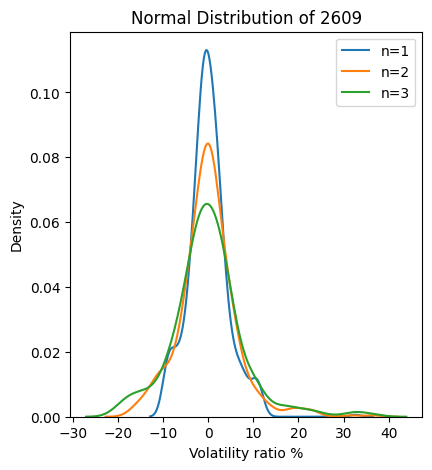

In [63]:
plt.figure(figsize=(10, 5))

# 繪製第一個子圖（data1 的正態分佈）
plt.subplot(1, 2, 1)
sns.kdeplot(list_2603[0],  label="n=1")
sns.kdeplot(list_2603[1],  label="n=2")
sns.kdeplot(list_2603[2],  label="n=3")
plt.title("Normal Distribution of 2609")
plt.xlabel("Volatility ratio %")
plt.ylabel("Density")
# 顯示圖例
plt.legend()

plt.show()

In [57]:
# 假設您想要計算 70% 的區間
confidence_level = 0.70

# 針對 list_2603 中的每個元素，計算平均值和標準差
for data in list_2603:
    mean = np.mean(data)
    std_dev = np.std(data)

    # 計算區間
    interval = stats.norm.interval(confidence_level, loc=mean, scale=std_dev)

    # 計算區間外剩餘的部分
    remaining_lower = stats.norm.cdf(interval[0], loc=mean, scale=std_dev)
    remaining_upper = 1 - stats.norm.cdf(interval[1], loc=mean, scale=std_dev)

    print(f"區間：{interval}")
    print(f"剩餘的部分：下限：{remaining_lower}，上限：{remaining_upper}")

區間：(-4.649822699588071, 4.587331573049784)
剩餘的部分：下限：0.1499999999999999，上限：0.1499999999999999
區間：(-6.756406749296339, 6.647721879461082)
剩餘的部分：下限：0.1499999999999999，上限：0.1499999999999999
區間：(-8.426423187431451, 8.232754404545675)
剩餘的部分：下限：0.1499999999999999，上限：0.1499999999999999
區間：(-9.946419517760528, 9.653296964932391)
剩餘的部分：下限：0.1499999999999999，上限：0.1499999999999999
區間：(-11.263850114020014, 10.88949659156046)
剩餘的部分：下限：0.1499999999999999，上限：0.1499999999999999


* 根據以上結果選擇以4%來設為漲跌幅

In [10]:
#定義參數
n = 1
price_threshold = 4
volume_high_threshold = 1.1
volume_low_threshold = 0.9

In [11]:
# 獲取篩選資料
filtered_2609 = process_data(df, "2609 陽明", n, price_threshold, volume_high_threshold,volume_low_threshold)
filtered_2609['標記'] = filtered_2609['相對差異'].apply(mark_up_down)

print(len(filtered_2609))
print(filtered_2609)

124
               年月日       相對差異  過去10天平均交易量  標記
68838   2022/10/17   4.666667     49384.7   1
70102   2022/10/14  -5.573248     51308.8   0
84007   2022/09/28   5.804312     56696.3   1
86537   2022/09/26   9.415584     62753.3   1
92870   2022/09/19   8.088235     65755.5   1
99205   2022/09/12  -4.507042     55557.5   0
105540  2022/09/02   8.016878     56607.7   1
110608  2022/08/29   4.773869     54322.1   1
123285  2022/08/15   4.114286     31796.1   1
151215  2022/07/14  -4.114286     45796.2   0
153755  2022/07/12   7.429963     52458.0   1
160105  2022/07/05  -4.750305     64857.1   0
162645  2022/07/01   5.784062     73690.4   1
165185  2022/06/29   7.251462     86753.8   1
166455  2022/06/28  -6.106870     94832.7   0
170269  2022/06/23   4.989612    111187.1   1
176629  2022/06/16   4.273499    117194.0   1
180445  2022/06/13   4.564340     92152.3   1
198257  2022/05/23  -7.480276     53067.0   0
217368  2022/04/29  -4.365102     57516.5   0
222480  2022/04/25   4.115223 

* 把日期與漲跌存成dict來作為新聞的篩選日期與標記

In [12]:
# 將"年月日"和"標記" 欄位的值提取為元組列表
filtered_date = list(filtered_2609[["年月日", "標記"]].itertuples(index=False, name=None))
# 將 tuple 列表轉換為字典
filtered_date = {pd.to_datetime(date).date(): value for date, value in filtered_date}


# 讀取切詞檔案，並抓出符合條件的資料，並做關鍵字篩選

In [14]:
#讀取切好辭的新聞資料
tokenization_df = pd.DataFrame()

# 讀取csv文件檔名
file_list = ['mid_forum_OK.csv','mid_bbs_OK.csv','mid_news_OK.csv']

# 讀取並連接所有文件
for file in file_list:
    temp_df = pd.read_csv('./output/'+file,encoding='utf-8-sig')
    print(f'read file {file} success!')
    tokenization_df = pd.concat([tokenization_df, temp_df], ignore_index=True)
    
# 將日期字符串轉換為 datetime 對象，僅保留年月日部分
tokenization_df['post_time'] = pd.to_datetime(tokenization_df['post_time']).dt.date

read file mid_forum_OK.csv success!
read file mid_bbs_OK.csv success!
read file mid_news_OK.csv success!


In [15]:
traing_df = tokenization_df.copy()

In [16]:
# 給新聞資料traing_df 透過filtered_date標記漲跌，去除沒有標記的資料
traing_df['標記'] = traing_df['post_time'].apply(lambda x: filtered_date.get(x, None))

# 僅保留具有有效標記的行
traing_df = traing_df[traing_df['標記'].notnull()]
traing_df = traing_df.dropna()

In [18]:
#儲存資料作為後續分類與訓練用
traing_df.to_csv(f'./output/traing_df_2609.csv', index=False, encoding='utf-8-sig')


# 關鍵字篩選

* 用TfidfVectorizer 計算tfidf,n-gram 。
* 再透過 chi-square找出漲跌類最具代表的辭
* 把以上結果在與LDA 15個topic的前20個辭做交集來作為最終的關鍵詞

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

In [23]:
import numpy as np

In [42]:
#透過TfidfVectorizer計算tf-idf與ngram_range(1,4)的關鍵詞
def get_top_k_keywords(data, k=500):
    vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_features=1000,min_df=0.01, max_df=0.95)
    X_tfidf = vectorizer.fit_transform(data['content'])

    # 取前 k 個 tf-idf 最高的關鍵詞
    top_k_indices = np.argsort(X_tfidf.toarray().sum(axis=0))[-k:]
    selected_feature_names = np.array(vectorizer.get_feature_names_out())[top_k_indices]
  
    return set(selected_feature_names)


# 根據漲跌標記分成兩個子集
up_train_data = traing_df[traing_df['標記'] == 1].reset_index()
down_train_data = traing_df[traing_df['標記'] == 0].reset_index()

# 分別取出各前 500 個 tf-idf 關鍵詞
up_keywords = get_top_k_keywords(up_train_data)
down_keywords = get_top_k_keywords(down_train_data)


# 合併關鍵詞並消除重複
combined_keywords = up_keywords.union(down_keywords)
print(len(combined_keywords))

# 使用合併後的關鍵詞計算全體數據的 tf-idf
vectorizer = TfidfVectorizer(vocabulary=combined_keywords)
X_tfidf = vectorizer.fit_transform(traing_df['content'])
y = traing_df['標記']

# 使用 chi2 函數選擇前 400 個關鍵詞
k_best = SelectKBest(chi2, k=400)
X_k_best = k_best.fit_transform(X_tfidf, y)
selected_feature_names = np.array(vectorizer.get_feature_names_out())[k_best.get_support()]


568


In [28]:
#轉換資料每個辭為一個index，作為LDA模型的輸入
traing_df['content_2'] = traing_df['content'].apply(lambda x: x.split())

* 透過LDA模型來做主題分析，尋找相關的pattern

In [30]:
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

In [31]:
docs = traing_df['content_2']

# 創建一個bag of words
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

# 定根據主题數量訓練LDA模型並計算Coherence Score，取最佳Coherence Score的LDA模型
def train_and_evaluate_lda(corpus, dictionary, texts, num_topics):
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('coherence_score:',coherence_score)
    return lda_model, coherence_score

# 嘗試不同的主题数量並計算Coherence Score
num_topics_range = [3 ,5, 10, 15, 20]
models_and_scores = [train_and_evaluate_lda(corpus, dictionary, docs, num_topics) for num_topics in num_topics_range]

# 選擇Coherence Score最高的模型
best_lda_model, best_coherence_score = max(models_and_scores, key=lambda x: x[1])

coherence_score: 0.4563326948675796
coherence_score: 0.4777349747023788
coherence_score: 0.5434271749447107
coherence_score: 0.5511249937436282
coherence_score: 0.5345153981409546


In [51]:
# 取出每個topic前100個keyword
num_top_keywords = 100
lda_keywords = set()
for i in range(best_lda_model.num_topics):
    topic_terms = best_lda_model.get_topic_terms(i, topn=num_top_keywords)
    for term_id, _ in topic_terms:
        lda_keywords.add(dictionary[term_id])

# 將selected_feature_names轉換為一個set
selected_feature_names_set = set(selected_feature_names)

# 合并使用 chi-square 和 LDA 方法找到的关键词
combined_keywords_chi_lda = selected_feature_names_set.intersection(lda_keywords)

print("使用 chi-square 和 LDA 方法找到的關鍵辭：")

print(len(combined_keywords_chi_lda))

使用 chi-square 和 LDA 方法找到的關鍵辭：
284


In [52]:
# 將 selected_feature_names 轉換為 DataFrame
selected_feature_names_df = pd.DataFrame(combined_keywords_chi_lda, columns=['keyword'])

# 輸出 DataFrame 到 CSV 檔案
selected_feature_names_df.to_csv('./output/2609_selected_keywords_n14_chi_in_lda.csv', index=False)